### LSTM 1 hour rate prediction

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mysql.connector
from mysql.connector import Error
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import utils as ut

In [ ]:
connection = ut.connect_to_database()

if connection:
    # Query merged data
    merged_df = ut.query_merged_crypto_data(connection)
    if merged_df is not None and not merged_df.empty:
        # Save DataFrame to CSV
        merged_df.to_csv('merged_crypto_data.csv', index=False)
    else:
        print("\nNo data found after merging.")

    # Close the connection
    ut.query_quit(connection)

In [ ]:
# Drop the second occurrence of a specific column
merged_df = pd.read_csv("E:\Funding_rate_Aave\merged_crypto_data.csv")
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
# data without NA rows if we needed 
filtered_df = merged_df[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df.reset_index(inplace=True, drop=True)
# date formatting
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
# taking the columns we want and converting them to floats
filtered_df = filtered_df[['crypto_symbol', 'date', 'lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']]
filtered_df[['lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)


In [ ]:
# Initialize empty lists to store aggregated inputs and targets
all_inputs = []
all_targets = []

# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
for s in symbols:
     sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
     sim_df.reset_index(inplace=True, drop=True)
     print(s, len(sim_df))
     # First Loop: Calculate intervals for each column without modifying the DataFrame
     intervals = {}
     for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
          lower, upper = ut.calculate_iqr_bounds(sim_df[column])
          intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

     # Second Loop: Filter rows based on the pre-calculated intervals
     reduced_df = sim_df.copy()
     for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
          lower_bound = intervals[column]['lower_bound']
          upper_bound = intervals[column]['upper_bound']
          # Apply filtering based on pre-calculated bounds
          reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

     reduced_df['returns'] = ut.calculate_hourly_returns(reduced_df, 'date', 'close')

     # MinMax scaling
     scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

     scaled_df = reduced_df.copy()
     scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
     scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
     scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
     scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
     scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
     scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

     inputs, targets = ut.extract_valid_windows(
          scaled_df,
          'date', 
          40, 5, 
          ['lending_rate',	'borrowing_rate','utilization_rate', 'close', 'volume'], 
          ['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume']
          )
     
     # Append results from the current DataFrame
     all_inputs.append(inputs)
     all_targets.append(targets)
     

# Concatenate all inputs and targets into single arrays
all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])
     
all_inputs = np.nan_to_num(all_inputs)

BATUSDT 28159
LINKUSDT 31934
KNCUSDT 27690
MKRUSDT 30094
MANAUSDT 27145
ZRXUSDT 28255
SNXUSDT 31087
WBTCUSDT 11729
ENJUSDT 27034
RENUSDT 27658
YFIUSDT 29900
UNIUSDT 29885
CRVUSDT 28455
BALUSDT 24855
ENSUSDT 20745
1INCHUSDT 14025


In [ ]:
print(all_inputs.shape)
print(all_targets.shape)

(118176, 40, 5)
(118176, 5, 5)


In [ ]:
merged_df.describe()

,id,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,high,low,close,adj_close,volume,market_cap,coin_supply
count,487675.000000,487675.000000,487675.000000,487675.000000,487675.000000,487675.000000,487675.000000,487675.000000,487675.000000,4.876750e+05,0.0,0.0
mean,257489.589753,-6.948210,-6.993978,0.092806,-7.624744,2479.657035,2447.360560,2463.879616,2463.879616,4.879314e+05,NaN,NaN
std,151890.908449,17.313302,17.452229,1.926008,18.045787,9432.305782,9317.047389,9376.023619,9376.023619,1.997177e+06,NaN,NaN
min,1.000000,-50.000000,-50.000000,-58.525084,-50.000000,0.030000,0.020000,0.030000,0.030000,0.000000e+00,NaN,NaN
25%,122567.500000,0.000003,0.002538,0.006045,0.007954,0.490000,0.480000,0.490000,0.490000,1.864000e+04,NaN,NaN
50%,267448.000000,0.000293,0.016319,0.067170,0.034076,2.300000,2.250000,2.270000,2.270000,1.364230e+05,NaN,NaN
75%,390710.500000,0.003802,0.088877,0.213107,0.064000,15.300000,15.020000,15.160000,15.160000,4.355500e+05,NaN,NaN
max,515214.000000,32.305099,55.626264,25.449307,3.130000,95000.000000,86240.000000,90500.000000,90500.000000,4.634977e+08,NaN,NaN


In [ ]:
# using GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")
else:
    print("No GPUs detected, using CPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
input_window = 40
target_window = 5
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume']
target_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume']

# 2. train test split
X_train, X_test, y_train, y_test = train_test_split(all_inputs, all_targets, test_size=0.2, random_state=42)

# 3. establish the 
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(input_window, len(input_columns)), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(target_window * len(target_columns)),
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=20, batch_size=32, validation_split=0.2)

# 5. validate the model
test_loss, test_mae = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1))
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# 6. calculate predictions
predictions = model.predict(X_test)



Epoch 1/20
2364/2364 [==============================] - 16s 6ms/step - loss: 0.0025 - mae: 0.0285 - val_loss: 7.7580e-04 - val_mae: 0.0118
Epoch 2/20
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0014 - mae: 0.0215 - val_loss: 7.7327e-04 - val_mae: 0.0129
Epoch 3/20
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0013 - mae: 0.0211 - val_loss: 7.7198e-04 - val_mae: 0.0132
Epoch 4/20
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0013 - mae: 0.0210 - val_loss: 6.6906e-04 - val_mae: 0.0100
Epoch 5/20
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0013 - mae: 0.0210 - val_loss: 7.2620e-04 - val_mae: 0.0118
Epoch 6/20
2364/2364 [==============================] - 15s 6ms/step - loss: 0.0013 - mae: 0.0208 - val_loss: 6.7274e-04 - val_mae: 0.0100
Epoch 7/20
2364/2364 [==============================] - 14s 6ms/step - loss: 0.0013 - mae: 0.0206 - val_loss: 7.3939e-04 - val_mae: 0.0131
Epoch 8/20
2364/2364 [=====

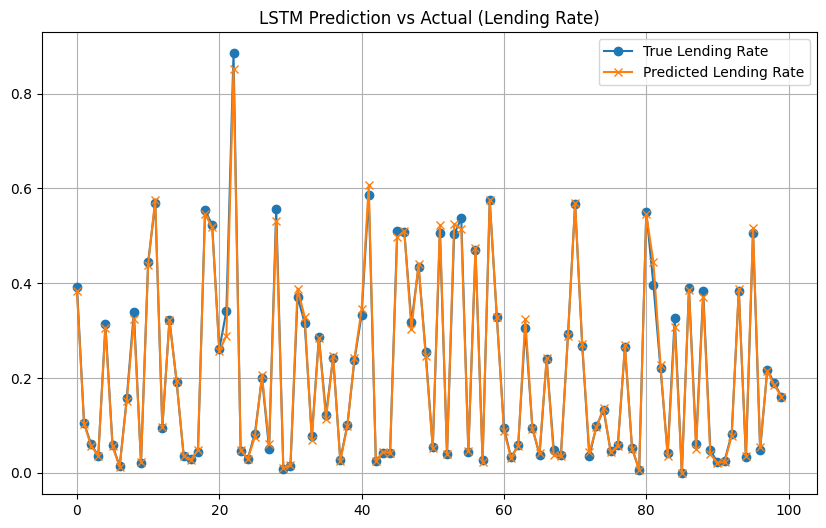

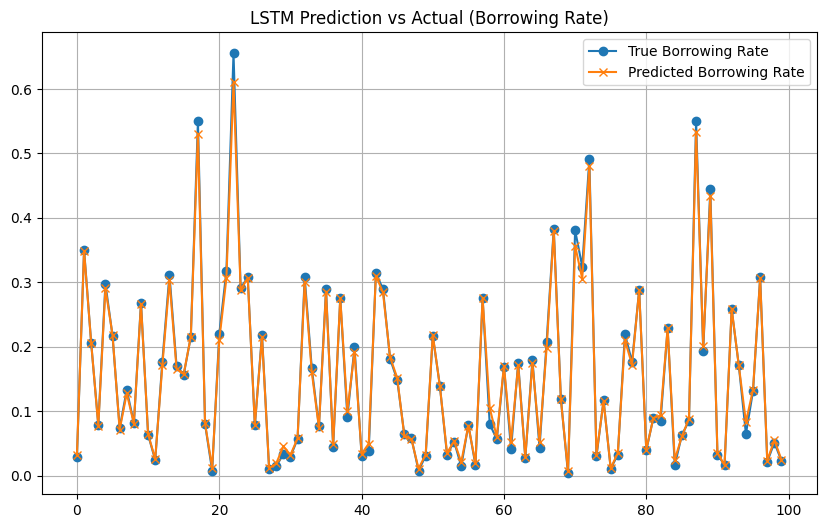

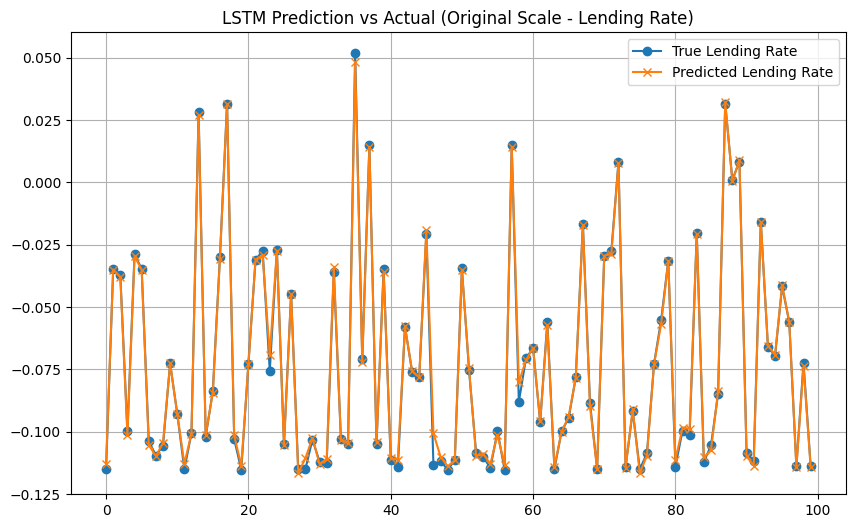

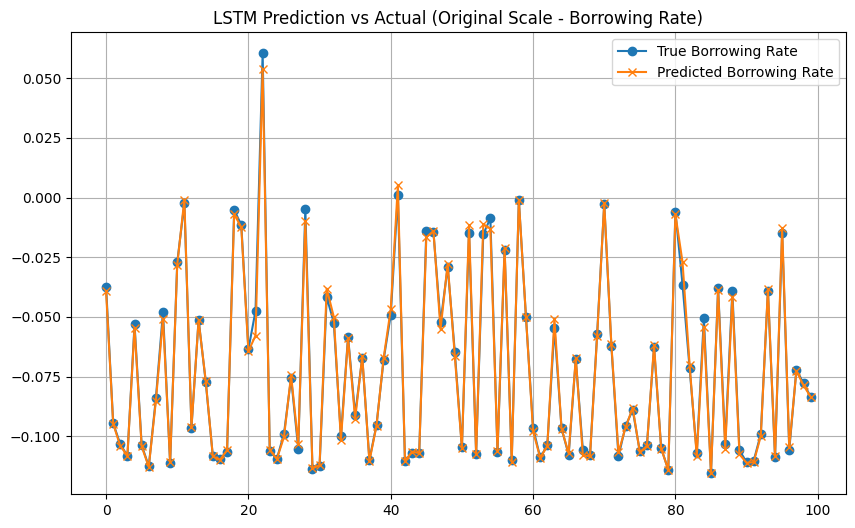

In [ ]:
# 7. Visualization
# Plot the actual and predicted Lending Rate
x = 5000
plt.figure(figsize=(10, 6))
plt.plot(y_test[x:x+100, 4, 3], label="True Lending Rate", marker='o')
plt.plot(predictions[x:x+100, 4*5+3], label="Predicted Lending Rate", marker='x')
plt.title("LSTM Prediction vs Actual (Lending Rate)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the actual and predicted Borrowing Rate
plt.figure(figsize=(10, 6))
plt.plot(y_test[x:x+100, 0, 1], label="True Borrowing Rate", marker='o')
plt.plot(predictions[x:x+100, 1], label="Predicted Borrowing Rate", marker='x')
plt.title("LSTM Prediction vs Actual (Borrowing Rate)")
plt.legend()
plt.grid(True)
plt.show()

# Reverse the scaling of y_test and predictions for visualization in original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)
predictions_original = scaler.inverse_transform(predictions.reshape(-1, predictions.shape[-1])).reshape(predictions.shape)

# Plot the original scale Lending Rate (true vs predicted)
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[x:x+100, 0, 0], label="True Lending Rate", marker='o')
plt.plot(predictions_original[x:x+100, 0], label="Predicted Lending Rate", marker='x')
plt.title("LSTM Prediction vs Actual (Original Scale - Lending Rate)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the original scale Borrowing Rate (true vs predicted)
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[x:x+100, 4, 3], label="True Borrowing Rate", marker='o')
plt.plot(predictions_original[x:x+100, 4*5+3], label="Predicted Borrowing Rate", marker='x')
plt.title("LSTM Prediction vs Actual (Original Scale - Borrowing Rate)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
predictions[1, :len(target_columns)]

array([0.61043173, 0.4938509 ], dtype=float32)

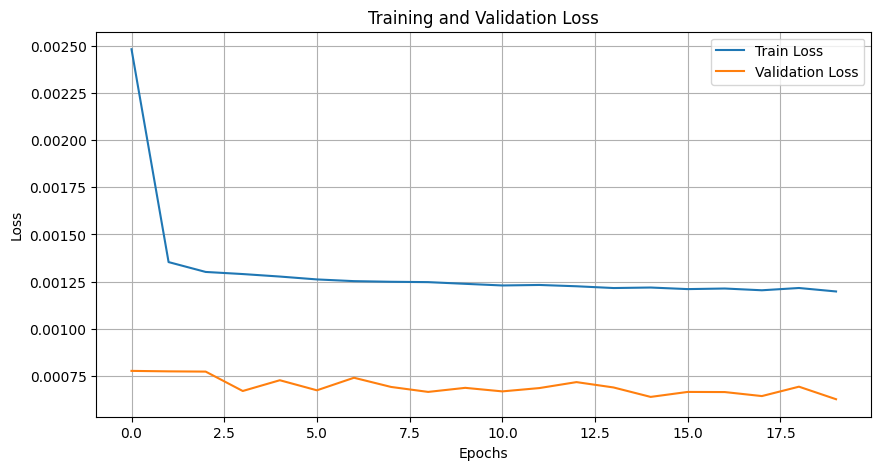

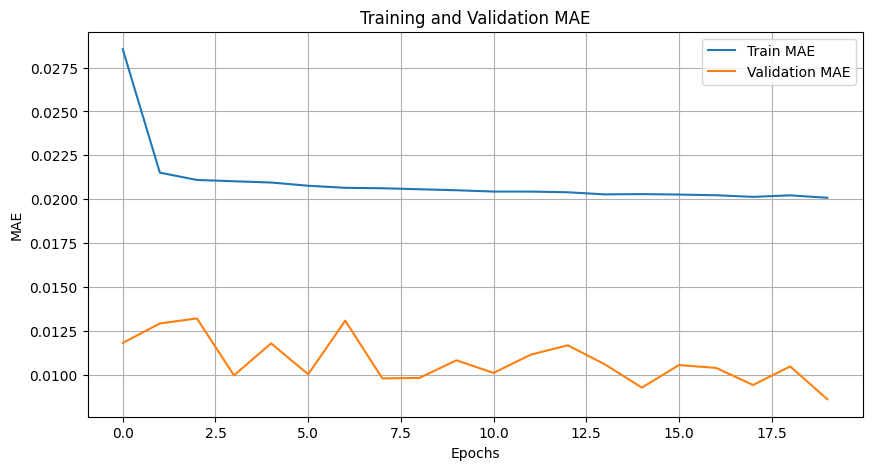

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# mae curve
plt.figure(figsize=(10, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

### End of Notebook